# HOMEWORK 1

1. Use exactly the same architectures (both densely connected layers and from convolutional layers) as the above MNIST e.g., replace the dataset. Save the Jupyter Notebook in its original format and output a PDF file after training, testing, and validation. Make sure to write down how do they perform (training accuracny, testing accuracy).

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# import torchvision
# import torchvision.transforms as transforms

from datetime import datetime

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from PIL import Image
#import torchvision.transforms as T

In [4]:
mnist_dataset = FashionMNIST(root = 'data/', download=True, train = True, transform = transforms.ToTensor())
print(mnist_dataset)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.55MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.9MB/s]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
# mnist_dataset has 'images as tensors' so that they can't be displayed directly
sampleTensor, label = mnist_dataset[10]
print(sampleTensor.shape, label)
tpil = transforms.ToPILImage() # using the __call__ to
image = tpil(sampleTensor)
image.show()

torch.Size([1, 28, 28]) 0


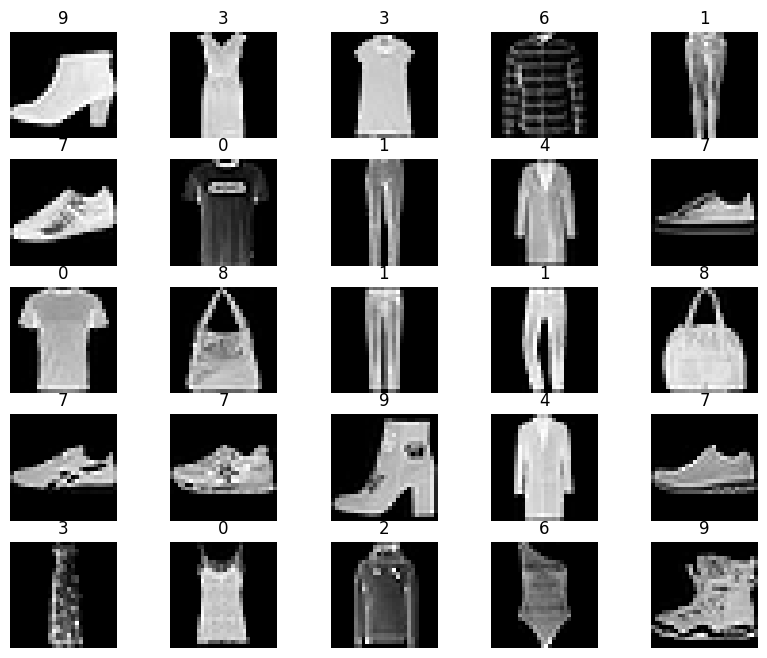

In [6]:
# Print multiple images at once
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item()
    img, label = mnist_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)
## MNIST data from pytorch already provides held-out test set!

length of Train Datasets:  50000
length of Validation Datasets:  10000


## Densely Connected Layers

In [8]:
## Basic set up for a logistic regression model (won't be used in practice or for training)
input_size = 28 * 28
num_classes = 10

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)

    # We add extra methods
    def training_step(self, batch):
        # when training, we compute the cross entropy, which help us update weights
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        # in validation, we want to also look at the accuracy
        # idealy, we would like to save the model when the accuracy is the highest.
        acc = accuracy(out, labels) ## calculate metrics/accuracy
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        # at the end of epoch (after running through all the batches)
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        # log epoch, loss, metrics
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# we instantiate the model
model = MnistModel()

# a simple helper function to evaluate
def evaluate(model, data_loader):
    # for batch in data_loader, run validation_step
    outputs = [model.validation_step(batch) for batch in data_loader]
    return(model.validation_epoch_end(outputs))

# actually training
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        ## Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() ## backpropagation starts at the loss and goes through all layers to model inputs
            optimizer.step() ## the optimizer iterate over all parameters (tensors); use their stored grad to update their values
            optimizer.zero_grad() ## reset gradients

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [9]:
result0 = evaluate(model, val_loader)
history1 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7071, val_acc: 0.6139
Epoch [1], val_loss: 1.4182, val_acc: 0.6486
Epoch [2], val_loss: 1.2508, val_acc: 0.6602
Epoch [3], val_loss: 1.1428, val_acc: 0.6687
Epoch [4], val_loss: 1.0673, val_acc: 0.6766
Epoch [5], val_loss: 1.0112, val_acc: 0.6865
Epoch [6], val_loss: 0.9675, val_acc: 0.6997
Epoch [7], val_loss: 0.9319, val_acc: 0.7086
Epoch [8], val_loss: 0.9027, val_acc: 0.7176
Epoch [9], val_loss: 0.8783, val_acc: 0.7234


Text(0.5, 1.0, 'Accuracy over epochs')

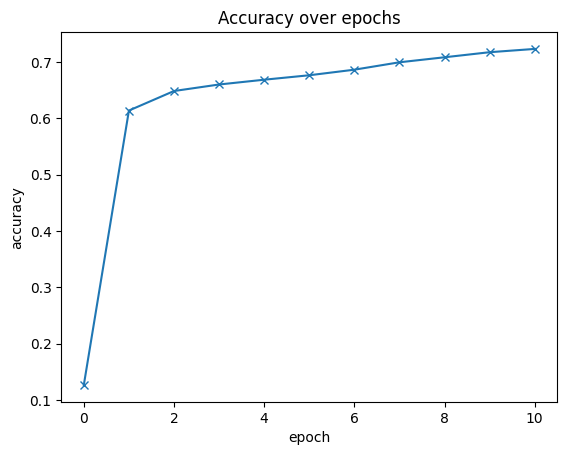

In [10]:
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

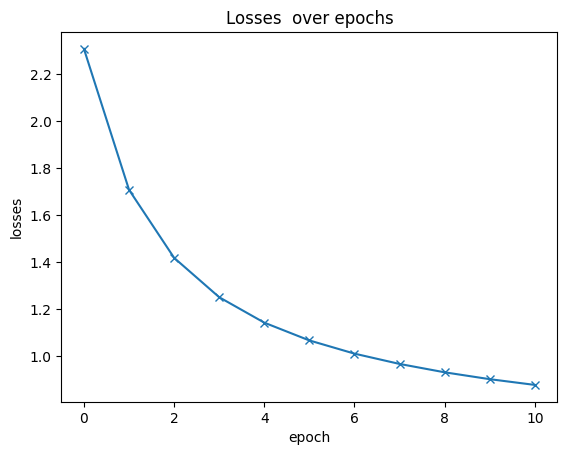

In [11]:
history = [result0] + history1
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

In [12]:
test_dataset = FashionMNIST(root = 'data/', train = False, transform = transforms.ToTensor())
print("Length of Test Datasets: ", len(test_dataset))

Length of Test Datasets:  10000


In [13]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

img, label = test_dataset[0]
print('Label:', label, ', Predicted :', predict_image(img, model))

Label: 9 , Predicted : 9


In [14]:
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8976536989212036, 'val_acc': 0.7098633050918579}

## Convolutional Neural Network

In [15]:
from torch.autograd import Variable


# We construct a fundamental CNN class.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

def train(num_epochs, cnn, loaders):
    cnn.train()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
    loss_func = nn.CrossEntropyLoss()
    # Train the model
    total_step = len(loaders)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass

cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

In [16]:
# instiate the CNN model
cnn = CNN()
# for testing purpose, we calculate the accuracy of the initial
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Accuracy of the model on the 10000 test images: %.2f' % accuracy)

Accuracy of the model on the 10000 test images: 0.12


In [17]:
train(num_epochs=5, cnn=cnn, loaders=train_loader)

Epoch [1/5], Step [100/391], Loss: 0.6291
Epoch [1/5], Step [200/391], Loss: 0.3726
Epoch [1/5], Step [300/391], Loss: 0.3942
Epoch [2/5], Step [100/391], Loss: 0.3629
Epoch [2/5], Step [200/391], Loss: 0.2464
Epoch [2/5], Step [300/391], Loss: 0.3419
Epoch [3/5], Step [100/391], Loss: 0.3246
Epoch [3/5], Step [200/391], Loss: 0.3172
Epoch [3/5], Step [300/391], Loss: 0.2295
Epoch [4/5], Step [100/391], Loss: 0.2171
Epoch [4/5], Step [200/391], Loss: 0.3050
Epoch [4/5], Step [300/391], Loss: 0.2730
Epoch [5/5], Step [100/391], Loss: 0.2591
Epoch [5/5], Step [200/391], Loss: 0.1774
Epoch [5/5], Step [300/391], Loss: 0.2415


In [18]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

Test Accuracy of the model on the 10000 test images: 0.91


In [19]:
sample = next(iter(test_loader))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [9 2 1 1 6 1 2 6 5 7]
Actual number: [9 2 1 1 6 1 4 6 5 7]


**2. Improve the architecture**. \\
Experiment with different numbers of layers, size of layers, number of filters, size of filters. You are required to make those adjustment to get the highest accuracy. Watch out for overfitting -- we want the highest testing accuracy!
Please provide a PDF file of the result, the best test accuracy and the architecture (different numbers of layers, size of layers, number of filters, size of filters)

**Model architecture:**

In [44]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output, x
cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [47]:
train(num_epochs=5, cnn=cnn, loaders=train_loader)

Epoch [1/5], Step [100/391], Loss: 0.4135
Epoch [1/5], Step [200/391], Loss: 0.3367
Epoch [1/5], Step [300/391], Loss: 0.2628
Epoch [2/5], Step [100/391], Loss: 0.3332
Epoch [2/5], Step [200/391], Loss: 0.2136
Epoch [2/5], Step [300/391], Loss: 0.3346
Epoch [3/5], Step [100/391], Loss: 0.4504
Epoch [3/5], Step [200/391], Loss: 0.2714
Epoch [3/5], Step [300/391], Loss: 0.3398
Epoch [4/5], Step [100/391], Loss: 0.1797
Epoch [4/5], Step [200/391], Loss: 0.2973
Epoch [4/5], Step [300/391], Loss: 0.3661
Epoch [5/5], Step [100/391], Loss: 0.2827
Epoch [5/5], Step [200/391], Loss: 0.2464
Epoch [5/5], Step [300/391], Loss: 0.2943


In [46]:
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass

print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

Test Accuracy of the model on the 10000 test images: 0.93
